In [1]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [52]:
# reload(S)
# S.scale()

['ID', 'TIME', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'ICU']
['ID', 'TIME', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20', 'L21', 'L22', 'L23', 'L24', 'L25']
['ID', 'AGE']
Column :  V1 max Value :  290.0 mean Value :  122.710736712 Mean by Max ratio :  0.42314047142
Column :  V1 Mean by Max ratio :  0.42314047142
Column :  V2 max Value :  200.0 mean Value :  69.2100425966 Mean by Max ratio :  0.346050212983
Column :  V2 Mean by Max ratio :  0.346050212983
Column :  V3 max Value :  219.0 mean Value :  86.8153202933 Mean by Max ratio :  0.39641698764
Column :  V3 Mean by Max ratio :  0.39641698764
Column :  V4 max Value :  82.0 mean Value :  20.4260971774 Mean by Max ratio :  0.249098746066
Column :  V4 Mean by Max ratio :  0.249098746066
Column :  V5 max Value :  102.0 mean Value :  97.6664309932 Mean by Max ratio :  0.957514029345
Column :  V5 Mean by Max ratio :  0.957514029345
Column :  V6 max Value :  1

In [72]:
# reload(F)
# F.getfeatures(
#     vital_file='Training_Dataset/vital_train.csv',
#     lab_file='Training_Dataset/lab_train.csv',
#     age_file='Training_Dataset/age_train.csv',
#     label_file='Training_Dataset/id_label_train.csv',
#     prefix=''
# )

Getting features...


KeyboardInterrupt: 

In [2]:
train_feats = pa.read_csv('train_feats.csv')
train_targets = pa.read_csv('train_targets.csv')
val_feats = pa.read_csv('validation_feats.csv')
val_targets = pa.read_csv('validation_targets.csv')

In [3]:
print train_targets.columns

Index([u'ID', u'TIME', u'LABEL', u'ICU'], dtype='object')


In [4]:
tx = np.asarray(train_feats, dtype=TH.config.floatX)
tyall = np.asarray(train_targets, dtype=TH.config.floatX)
ty = np.asarray(train_targets['LABEL'], dtype=TH.config.floatX).reshape(-1, 1)
vx = np.asarray(val_feats, dtype=TH.config.floatX)
vyall = np.asarray(val_targets, dtype=TH.config.floatX)
vy = np.asarray(val_targets['LABEL'], dtype=TH.config.floatX).reshape(-1, 1)

In [5]:
print tx.shape, tyall.shape, ty.shape, vx.shape, vyall.shape, vy.shape

(426092, 321) (426092, 4) (426092, 1) (152282, 321) (152282, 4) (152282, 1)


In [33]:
reload(LN)
nneta = LN.nnet(n_in=321, n_out=1, h_layers=[500,100],
                i_drop=None, l_drops=[0.3, 0.3], lam=0.0,
                nonlinearity=L.nonlinearities.rectify
           )
nneta.train(x=tx, y=ty, lrate=0.1, gamma=0.9, batch_size=1000, iters=100,
            testx=vx, testy=vy, filename='model.npz'
           )

Training ... 
Iteration 0, Loss = 0.0100931371527
Testing ...
Mean auc = 0.518331043779
Iteration 1, Loss = 0.00894643869939
Iteration 2, Loss = 0.00804043471446
Iteration 3, Loss = 0.00760570778822
Iteration 4, Loss = 0.00736488944889
Iteration 5, Loss = 0.00717027325458
Iteration 6, Loss = 0.0070868253886
Iteration 7, Loss = 0.00694967578581
Iteration 8, Loss = 0.00689584421218
Iteration 9, Loss = 0.00676242500052
Iteration 10, Loss = 0.00664706270059
Testing ...
Mean auc = 0.803206017661
Iteration 11, Loss = 0.00653950855226
Iteration 12, Loss = 0.00646453639266
Iteration 13, Loss = 0.00641271407889
Iteration 14, Loss = 0.00636154950689
Iteration 15, Loss = 0.00630035990581
Iteration 16, Loss = 0.00624740174028
Iteration 17, Loss = 0.00621528427863
Iteration 18, Loss = 0.00618710493947
Iteration 19, Loss = 0.00614539256974
Iteration 20, Loss = 0.00610232063328
Testing ...
Mean auc = 0.818300398507
Iteration 21, Loss = 0.00608065385172
Iteration 22, Loss = 0.00604998318666
Iteration 

In [34]:
probs = nneta.tester(vx)
print probs

[array([[  1.77385024e-04],
       [  1.41916156e-04],
       [  1.38019503e-04],
       ..., 
       [  1.00557031e-06],
       [  9.74531872e-07],
       [  7.02427428e-07]], dtype=float32)]


0.832006492365


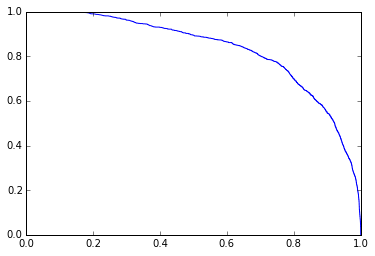

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

yscore = probs[0].ravel()
print roc_auc_score(vy, yscore)
fpr, tpr, thresh = roc_curve(vy, yscore)
pyplot.plot(1-fpr, tpr)

In [44]:
thresh = np.percentile(probs[0].ravel(), 99.4)
pred = np.int32(probs[0].ravel()>=thresh)
# for i in xrange(len(pred)):
#     id = np.int32(vyall[i,0])
#     if idtimes[id]-vyall[i,1] < 5*60*60:
#         pred[i] = 0
print np.sum(pred)

914


In [45]:
output = vyall.swapaxes(0,1)
output[2] = pred
output = output.swapaxes(0,1)

In [46]:
outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in output:
    if i[3] == 1:
        outfile.write(','.join([str(int(j)) for j in i])+'\n')
outfile.close()

In [47]:
reload(V)
V.validate('out.csv', './Training_Dataset/id_label_train.csv')

tp :  25 , tn :  831 , fp :  6 , fn :  35
sensitivity :  0.416666666667 , specificity :  0.992831541219
accuracy :  0.954292084727 median prediction time :  29.7591666667
finalScore :  40.9322057945


(0.4166666666666667,
 0.992831541218638,
 0.9542920847268673,
 29.759166666666665,
 40.93220579450421)